# ‫ تخمین ترافیک

‮یکی از کاربرد‌های شبکه‌های عصبی بازگشتی، حل کردن سری‌های زمانی است.
در یک سری زمانی، یک داده داریم که در طول زمان تغییر می‌کند و می‌خواهیم مقدار آن را در آینده پیش‌بینی کنیم.

‮
در این مسئله، به سراغ مسئله‌ی تخمین ترافیک می‌رویم. در کاربرد، پیدا کردن مسیری که کمترین مصرف سوخت/زمان را داشته باشد مسئله‌ی مهمی است که رکن اساسی آن، تخمین زدن این داده‌ها است.

‮ در این تسک پیش رو، داده‌ی بخشی از بزرگراه شیخ فضل الله شرق را داریم که در هر بازه‌ی زمانی، چقدر طول کشیده تا یک ماشین از این بخش عبور کند. این دیتا میانگینی از زمان عبوری کاربران نقشه‌ی بلد از این بخش از نقشه است.
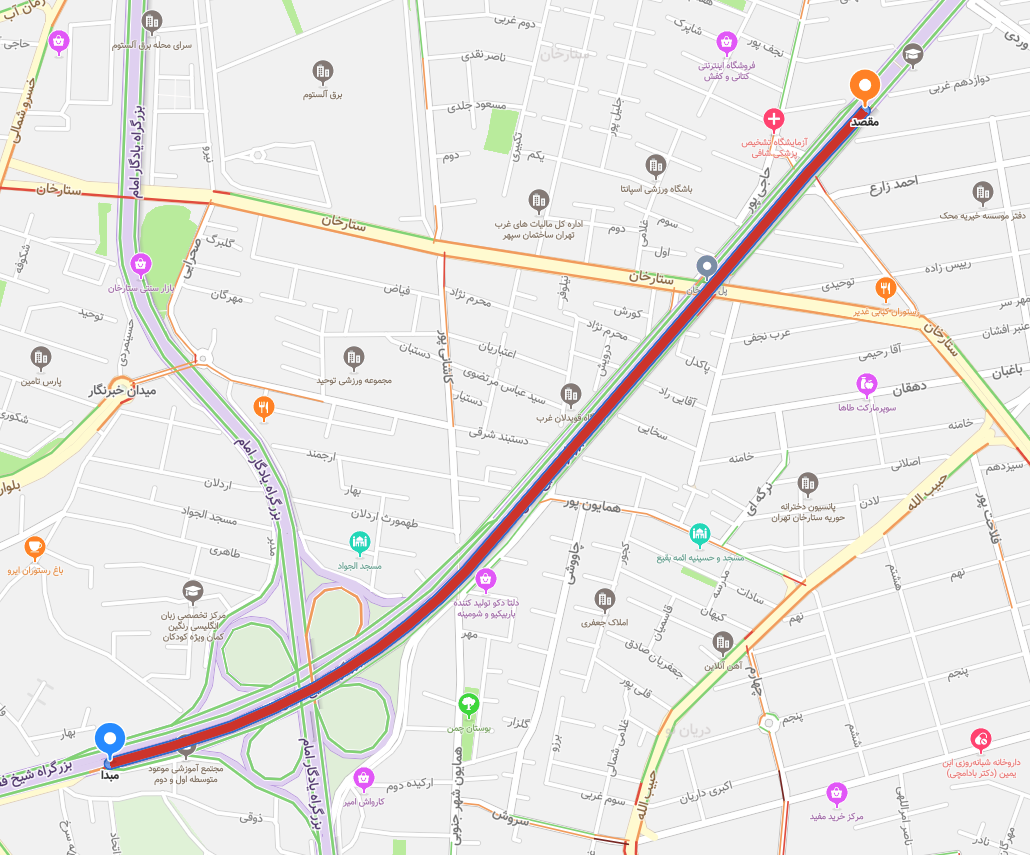

‮ تصویر بالا، این بخش از بزرگراه شیخ فصل الله را نشان می‌دهد که می‌خواهیم ترافیک آن را تخمین بزنیم. ( [تخمین لحظه‌ای زمان را از این لینک ببینید](https://balad.ir/directions/driving?origin=51.349133660074926%2C35.71336961801629&destination=51.36209852257423%2C35.722476456467064) )

‮ برای شروع، موارد مورد نیاز برای برنامه را وارد می‌کنیم.

In [21]:
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

from copy import deepcopy

import pandas
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


## ‫ پردازش اولیه‌ی داده

‫در این بخش، داده‌ی زمان عبور در هر دقیقه را لود و پردازش می‌کنیم.

‫ این داده در قالب یک فایل csv که شامل دو ستون است، ستون اول timestamp زمان است و ستون دوم، مدت زمانی که از این ناحیه از خیابان با اتومبیل به شکل میانگین در آن زمان می‌توان رد شد، به ثانیه است.

‫ ابتدا این داده را از گوگل درایو دانلود می‌کنیم و سپس با کمک pandas، آن را لود می‌کنیم.

In [22]:
!gdown 1ohJGv216qcHigCGXg0ya4XZujdqcFp9d --output duration_data.csv

Downloading...
From: https://drive.google.com/uc?id=1ohJGv216qcHigCGXg0ya4XZujdqcFp9d
To: /content/duration_data.csv
100% 2.19M/2.19M [00:00<00:00, 133MB/s]


In [23]:
def to_datetime(timestamp):
    return datetime.fromtimestamp(timestamp, tz=ZoneInfo('Asia/Tehran'))

In [24]:
df = pd.read_csv('duration_data.csv')

df

,timestamp,duration
0,1698784380,243.185486
1,1698784440,241.622870
2,1698784500,236.950365
3,1698784560,232.085945
4,1698784620,230.076888
...,...,...
74667,1703266080,531.672712
74668,1703266140,398.622804
74669,1703266200,405.043999
74670,1703266260,716.154641


‫ برای پردازش اولیه، بازه‌ی زمانی که داده در آن قرار دارد و تعداد ابعاد داده را چاپ می‌کنیم.

In [25]:
print(f"Data from {to_datetime(np.min(df['timestamp'])).isoformat()} to {to_datetime(np.max(df['timestamp'])).isoformat()}")

print('Rows:', df.shape)

Data from 2023-11-01T00:03:00+03:30 to 2023-12-22T21:02:00+03:30
Rows: (74672, 2)


### TODO:

‫ هیستوگرام زمان‌ها رد شدن در این این بازه را رسم کنید. براساس آن یک تخمین اولیه از مدت زمانی که عموما عبور از این محدوده طول می‌کشد به شکل rough بگویید.

average 507.3996177722755


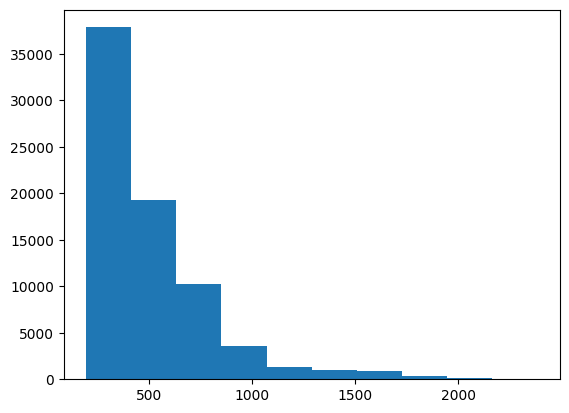

In [26]:
# Plot duration histogram

hist, bins=np.histogram(df['duration'])
bin_centers = (bins[:-1] + bins[1:]) / 2

# Compute the average using the histogram
average = np.average(bin_centers, weights=hist)
plt.hist(df['duration'])
print('average',average)

In [27]:
df['timestamp_date']=pd.to_datetime(df['timestamp'], unit='s')
df

,timestamp,duration,timestamp_date
0,1698784380,243.185486,2023-10-31 20:33:00
1,1698784440,241.622870,2023-10-31 20:34:00
2,1698784500,236.950365,2023-10-31 20:35:00
3,1698784560,232.085945,2023-10-31 20:36:00
4,1698784620,230.076888,2023-10-31 20:37:00
...,...,...,...
74667,1703266080,531.672712,2023-12-22 17:28:00
74668,1703266140,398.622804,2023-12-22 17:29:00
74669,1703266200,405.043999,2023-12-22 17:30:00
74670,1703266260,716.154641,2023-12-22 17:31:00


### TODO:

‫ در کد زیر، می‌خواهیم برای یک روز خاص، زمان عبور در کل آن روز را رسم کنیم. متغیر `day_num` شماره روز را که از ۱ شروع می‌شود مشخص می‌کند. دیتافریم به نام
`xth_day_df` بسازید که دیتافریم `df` را فیلتر کند و فقط داده‌های مربوط به روز `day_num`ام از دیتاست در آن باشد.

‫ ادامه‌ی کد‌ها دیتافریم `xth_day_df` را رسم می‌کند.

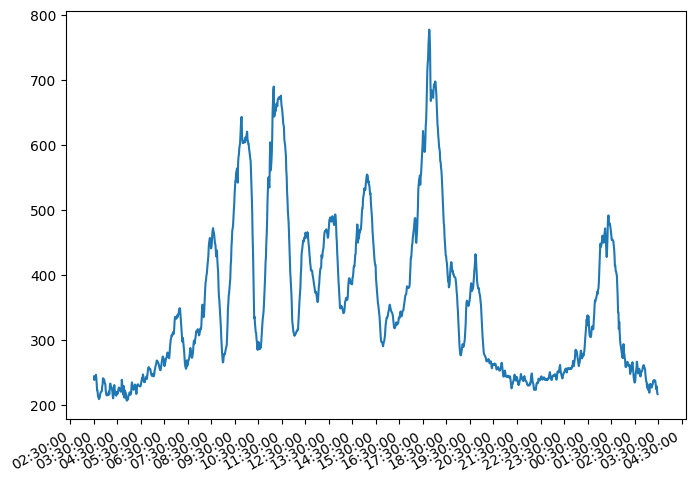

In [28]:
day_num = 51
start_timestamp = np.min(df['timestamp'])


# TODO
day_num=np.min(df['timestamp_date'].dt.dayofyear)+day_num
xth_day_df = df[df['timestamp_date'].dt.dayofyear==day_num]



fig, ax = plt.subplots(figsize=(8,6))

plt.plot([to_datetime(x) for x in xth_day_df.timestamp], xth_day_df.duration)

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S', tz=ZoneInfo('Asia/Tehran')))

fig.autofmt_xdate()


In [31]:
df.drop('timestamp_date',axis=1,inplace=True)
df

,timestamp,duration
0,1698784380,243.185486
1,1698784440,241.622870
2,1698784500,236.950365
3,1698784560,232.085945
4,1698784620,230.076888
...,...,...
74667,1703266080,531.672712
74668,1703266140,398.622804
74669,1703266200,405.043999
74670,1703266260,716.154641


## ‫حل مشکل نبودِ داده!

‫
تقریبا در این داده، برای هر ۶۰ ثانیه یک داده داریم، آرایه‌ی زیر را می‌سازیم که تایم‌استمپ هر سطر را منهای سطر قبلی کند و آن را بررسی می‌کنیم:

In [32]:
timestamp_diff = df.timestamp.diff()

print('Count of diff = 60:', np.sum(timestamp_diff == 60))
print('Count of diff < 60:', np.sum(timestamp_diff < 60))
print('Count of diff > 60:', np.sum(timestamp_diff > 60))

Count of diff = 60: 74650
Count of diff < 60: 0
Count of diff > 60: 21


‫
تعداد کمی جایگاه داریم که فاصله‌ی بیشتر از ۶۰ ثانیه وجود دارد، برای اینکه با داده کار کنیم، نیاز داریم که فاصله‌ی همه‌ی داده‌ها ۶۰ ثانیه باشد، اول ببینیم این فاصله تا چقدر زیاد است؟

In [33]:
print('maximum difference between each consecutive timestamps:', np.max(timestamp_diff))

maximum difference between each consecutive timestamps: 240.0


### TODO:

‫
حداکثر، به جای یک دقیقه، ۴ دقیقه فاصله است و ۳ داده در این وسط وجود ندارد، می‌خواهیم دیتافریم جدیدی به نام
interpolated_df
بسازیم که این مشکل را حل کند، فرض کنید جاهایی که داده نداریم به شکل خطی مقدار زمان رسیدن تغییر کرده و یک دیتافریم جدید بسازید که برای تمام دقایق داده داشته باشیم، داده‌هایی که در دیتافریم اصلی نیستند را از روی اینترپولیت کردن خطی داده‌های کناری به دست آورید. (مثلا اگر دقیقه‌ی ۱ داده داریم، دقیقه‌ی ۲ نداریم ولی ۳ داریم. مقدار زمان دقیقه‌ی ۲ را میانگین دقیقه‌ی اول و سوم بگیرید)

‫
خب، الآن یک دیتای اولیه داریم، سعی کنیم اولین مدل را برای پیش‌بینی آموزش دهیم.

## ‫ تخمین یک دقیقه‌ی قبل، براساس دقایق قبلی

‫
در شروع، باید دیتاست مخصوص این قسمت را بسازیم، اگر بخواهیم داده را لیبل و تارگت بزنیم، ورودی باید برداری از تعدادی عدد که داده‌های دقایق قبل است باشد و خروجی، زمان عبور در دقیقه‌ی بعد این داده‌ها. فرض کنید تعداد دقایقی که بررسی می‌کنیم (اندازه‌ی بردار) را با متغیر `LOOKBACK` نشان می‌دهیم.

‫ سپس این داده را به یک
RNN
بدهیم، انتظار داشته باشیم که در هر نوبت، حالت قبلی و بردار مربوط به ترافیک یک دقیقه را به آن بدهیم، سپس با کمک یک مدل یک لایه، مقدار ترافیک برای دقیقه‌ی بعد را پیشبینی کنیم.

‫ بیست درصد انتهایی داده‌ها را جهت تست جدا کنید، سپس از روی آن‌ها، به گونه‌ای که گفته شد، دیتاست بسازید!


In [34]:
TIMESTAMP_STEP = 60
expected_interpolated_df_rows = 1 + (np.max(df.timestamp)-np.min(df.timestamp)) // TIMESTAMP_STEP

# TODO: create interpolated_df
k=0
for i in range(1,int(expected_interpolated_df_rows)):

  if df['timestamp'][i]-df['timestamp'][i-1]>60:

    #number of gap between two successive timestamp

    num_gap=(df['timestamp'][i]-df['timestamp'][i-1])//TIMESTAMP_STEP
    # initialize timestamp for next row and index_to_add as well
    new_timestamp=df['timestamp'][i-1]+60
    index_to_add=i
    for j in range(int(num_gap)-1):

      new_row={'timestamp':new_timestamp,'duration':[np.nan]}
      new_row_d = pd.DataFrame(new_row, index=[index_to_add])

      # Concatenate the original DataFrame and the new row DataFrame
      df = pd.concat([df.loc[:index_to_add - 1], new_row_d, df.loc[index_to_add:]]).reset_index(drop=True)
      new_timestamp=new_timestamp+60
      index_to_add=index_to_add+1


interpolated_df = df
interpolated_df=interpolated_df.interpolate(method='linear')


In [35]:
all_timeseries = interpolated_df[['duration',]].values.astype('float32')
# we changed dtype to float32 to compatible with simple nn.LSTM/nn.RNN

# TODO:
train_timeseries =all_timeseries[:int(len(all_timeseries)*0.8)]
test_timeseries = all_timeseries[int(len(all_timeseries)*0.8):]

# TODO: normalize data
data_mean =np.mean(all_timeseries)
data_std = np.std(all_timeseries)

train_timeseries = (train_timeseries - data_mean) / data_std
test_timeseries = (test_timeseries - data_mean) / data_std

In [36]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print("Using device:", device)

True
Using device: cuda


‫ برای شروع مقدار تابع `create_dataset` را کامل کنید. این تابع، با ورودی کردن یک بردار که durationهای برای دقایق متوالی مثلا به اندازه‌ی n است، باید دو بردار `(n-lookback-1)*lookback*1` خروجی دهد،
$i$امین سطر از بردار، duration برای lookback دقیقه‌ی متوالیِ $i$ام خواهد بود و سطر متناظر با این سطر در بردار دوم، lookback دقیقه‌ی متوالیِ $i+1$ام خواهد بود.

‫
در واقع اگر از یک مدل RNNای استفاده کنیم، به طور متوالی یکی یکی عناصر سطر $i$ام را ورودی بدهیم، سپس استیت را برای مرحله بعد، و خروجی را خروجی بدهیم، lookbackتا خروجی داریم که تخمینی از سطر متناظر در بردار دوم خواهد بود.

In [37]:
def create_dataset(dataset, lookback, timeshift, sample_step):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of which first dimension is durations
        lookback: number of consequence minutes used as feature
        timeshift: number of next minutes to forcast
        sample_step:
    """
    X, y = [], []
    # we use only data of steps sample_step minutes to reduce train time.
    for i in range(0, len(dataset) - lookback - timeshift, sample_step):
        feature = dataset[i:i + lookback]
        target = dataset[i + timeshift :i + lookback + timeshift]
        X.append(feature)
        y.append(target)
    return torch.tensor(X, device=device), torch.tensor(y, device=device)



LOOKBACK = 15
TIMESHIFT = 1

X_train, y_train = create_dataset(train_timeseries, LOOKBACK, TIMESHIFT, 15)
X_test, y_test = create_dataset(test_timeseries, LOOKBACK, TIMESHIFT, 15)

### TODO:

‫
با کمک data.TensorDataset، از روی `X_train` و `y_train` یک دیتاست پایتورچی بسازید، سپس از روی آن یک دیتالودر می‌سازیم.

In [38]:
## TODO:
train_dataset = data.TensorDataset(X_train,y_train )

train_dataloader = data.DataLoader(train_dataset, shuffle=True, batch_size=8)

### TODO:

‫ اکنون یک مدل بسازید که شامل یک لایه‌ی RNN باشد، این لایه در خروجی یک استیت با اندازه‌ی ۳۰۰ بدهد. همچنین یک مدل دیپ، که برای ساختن خروجی استفاده شود داشته باشیم. این مدل فقط یک لایه‌ی میانی داشته باشد که به شکل fully-connected، استیت را به یک استیت ۱۰۰۰ تایی ببرد، سپس با اجرای activation function از خطی بودن آن بکاهد و سپس با یک لایه‌ی fully-connected دیگر، خروجی که یک عدد است را بدهد.

‫
مدل باید جوری طراحی شود که روی داده‌های بچ هم کار کند، به طور مثال کد‌هایی که به عنوان نمونه در اجرای کلاس زیر نوشته شده‌اند ارور ندهند و کار کنند.

In [39]:
class SimpleLookBackRNNModel(nn.Module):
    def __init__(self,input_size=1, hidden_size=300,fully_connected_size=1000,output_size=1,num_layers=2):
        super().__init__()
        # TODO: implement
        self.rnn = nn.RNN(input_size =input_size,
                          hidden_size=hidden_size,num_layers=1,batch_first=True)

        self.batch_norm1 = nn.BatchNorm1d(15)
        self.linear1 = nn.Linear(hidden_size, fully_connected_size)

        self.af1 = nn.ReLU()
        self.batch_norm2 = nn.BatchNorm1d(15)
        self.linear2 = nn.Linear(fully_connected_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        #x = self.batch_norm1(x)
        x = self.af1(self.linear1(x))
        #x = self.batch_norm2(x)
        x = self.linear2(x)
        return x

batch_first = next(iter(train_dataloader))

sample_model = SimpleLookBackRNNModel().to(device)

print(batch_first[0].shape)
print(sample_model(batch_first[0]).shape)
# both of them should be: torch.Size([8, 15, 1])

torch.Size([8, 15, 1])
torch.Size([8, 15, 1])


### TODO:

‫ متغیر optimizer را با یک اپتیمایزر خوب و لرنینگ ریت مناسب این مسئله کامل کنید.

‫ تابع loss_fn لاس‌فانکشن ما خواهد بود، چون مسئله رگرسیون است، از MSE استفاده کنید.

‫
تعداد ایپاک‌ها را هم براساس نیازتان تغییر دهید.

‫
مسئله را روی داده‌ی ترین، ترین می‌کنیم و سپس مقدار ریشه‌ی میانگین خطای مربعات را برای داده‌ی تست و ترین محاسبه کرده‌ایم. در هر ایپاک، بخشی از نمودار تخمین زده شده توسط مدل برای تست کشیده شده‌است.


In [40]:
from sklearn.metrics import r2_score
# getting R^2 score
def R_2_score(X,real,Training=False,Print=False):

  """
  X is features for prediction
  real is real data for comparing with prediction
  if Training is false, entries data is test and vice versa.
  if Print is False we do not want to print r2 and show graph
  return is pandas. first column is real data and second is prediction
  """
  if Training==True:
    state_data='Training'

  else:
    state_data='test'

  y_pred = model1(X)* data_std + data_mean

  y_pred=y_pred.view(-1,)

  real_data=real * data_std + data_mean
  real_data=real_data.view(-1,)


  # Convert tensors to NumPy arrays
  real_data = real_data.cpu().numpy()
  y_pred = y_pred.detach().cpu().numpy()

  # Create a Pandas DataFram
  df = pd.DataFrame({
      'Real Data': real_data,
      'Predictions': y_pred
  })

  r2 = r2_score(df['Real Data'], df['Predictions'])
  if Print==True:

    plt.plot(real_data, c='b',label=f"real_training_{state_data}")
    plt.plot(y_pred, c='r',label=f"prediction_training_{state_data}")
    plt.legend()
    plt.show()



    print(f"R^2 Score_{state_data}:", r2)

    return df

  else:
    return r2


In [41]:
model1 = SimpleLookBackRNNModel().to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.0001)
# TODO:
loss_fn = nn.MSELoss()

train_losses = []
valid_losses = []

train_acc = []
valid_acc = []

n_epochs = 12
for epoch in range(n_epochs):
    model1.train()
    for X_batch, y_batch in train_dataloader:

        y_pred = model1(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model1.eval()
    with torch.no_grad():
        y_pred = model1(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train).cpu().item())  # Move loss to CPU and convert to numpy

        acc_train = R_2_score(X_train, y_train, Training=True)  # Move data to CPU
        train_losses.append(train_rmse)
        train_acc.append(acc_train)

        y_pred = model1(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test).cpu().item())  # Move loss to CPU and convert to numpy
        acc_test = R_2_score(X_test, y_test)  # Move data to CPU
        valid_losses.append(test_rmse)
        valid_acc.append(acc_test)
        print("Epoch %d: train RMSE %.4f, train acc_train %.4f , test RMSE %.4f, test acc_test %.4f" % (epoch, train_rmse,acc_train ,test_rmse,acc_test))




Epoch 0: train RMSE 0.0677, train acc_train 0.9958 , test RMSE 0.0538, test acc_test 0.9953
Epoch 1: train RMSE 0.0505, train acc_train 0.9977 , test RMSE 0.0448, test acc_test 0.9967
Epoch 2: train RMSE 0.0485, train acc_train 0.9978 , test RMSE 0.0430, test acc_test 0.9970
Epoch 3: train RMSE 0.0488, train acc_train 0.9978 , test RMSE 0.0438, test acc_test 0.9969
Epoch 4: train RMSE 0.0464, train acc_train 0.9980 , test RMSE 0.0419, test acc_test 0.9971
Epoch 5: train RMSE 0.0461, train acc_train 0.9980 , test RMSE 0.0417, test acc_test 0.9972
Epoch 6: train RMSE 0.0467, train acc_train 0.9980 , test RMSE 0.0429, test acc_test 0.9970
Epoch 7: train RMSE 0.0510, train acc_train 0.9976 , test RMSE 0.0434, test acc_test 0.9969
Epoch 8: train RMSE 0.0449, train acc_train 0.9981 , test RMSE 0.0394, test acc_test 0.9975
Epoch 9: train RMSE 0.0528, train acc_train 0.9974 , test RMSE 0.0437, test acc_test 0.9969
Epoch 10: train RMSE 0.0430, train acc_train 0.9983 , test RMSE 0.0388, test acc

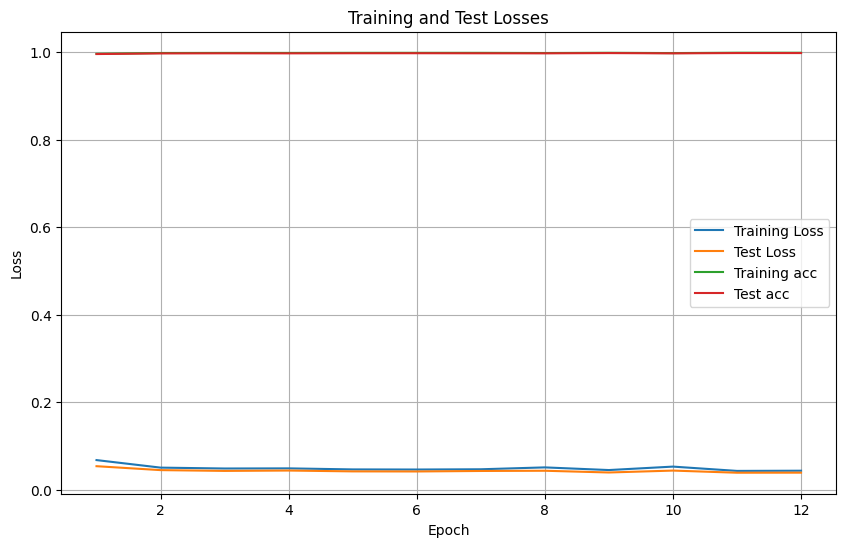

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs+1), valid_losses, label='Test Loss')
plt.plot(range(1, n_epochs+1), train_acc, label='Training acc')
plt.plot(range(1, n_epochs+1), valid_acc, label='Test acc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.grid(True)
plt.show()

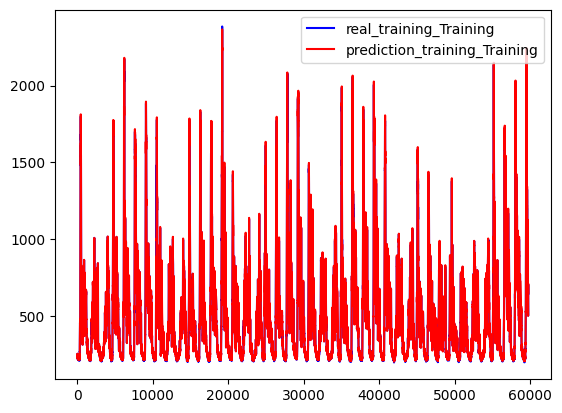

R^2 Score_Training: 0.9982664675951579


,Real Data,Predictions
0,241.622864,241.881058
1,236.950363,239.070847
2,232.085938,236.667328
3,230.076874,232.166656
4,231.192352,229.771210
...,...,...
59740,679.890381,682.398682
59741,675.281372,672.493958
59742,664.218323,668.864563
59743,657.504028,657.040283


In [43]:
Data=R_2_score(X_train,y_train,True,True)
Data

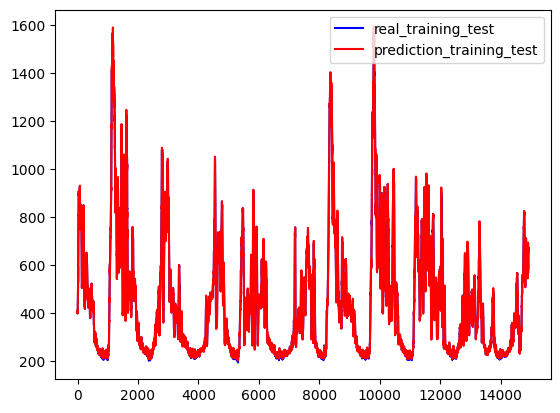

R^2 Score_test: 0.9975157342375592


,Real Data,Predictions
0,399.850922,400.340607
1,407.646057,398.206024
2,407.673981,408.592133
3,401.525696,409.408447
4,397.921021,401.297852
...,...,...
14920,671.768921,669.085999
14921,671.687256,672.294434
14922,617.459167,671.066772
14923,590.662170,600.804382


In [44]:
Data=R_2_score(X_test,y_test,Print=True)
Data

### TODO:

‫
آیا در این مدل، درگیر overfiting شده‌ایم؟ مقدار‌های هایپرپارامتر‌ها را تیون کنید.

‫
مقدار RSME اعلام شده برای داده‌ی تست آیا مناسب است و مدل کار جدی‌ای می‌کند؟ برای آزمایش، فرض کنید مدلی فرضی داشتیم که دقیقا میزان ترافیک دقیقه‌ی قبل را برای دقیقه‌ی بعد پیش‌بینی می‌کرد، میزان RSME آن را نیز محاسبه کنید و با مدلی که آموزش داده‌اید مقایسه کنید.

## ‫ تخمین زمان دورتر با مدل قبل!

### TODO:
‫
چون یک مدل
RNN‌
‌ای داریم، می‌توانیم بیش از یک دقیقه را تخمین بزنیم، فرض کنید می‌خواهیم با ورودی گرفتن داده‌ی دقایق قبل، داده‌ی $K$ دقیقه‌ی بعد را تخمین بزنیم.

‫
تابع `pred_next_Kmins` را طوری کامل کنید که با ورودی کردن یک بردار از بردارهای زمان عبور نرمال شده از دقایق متوالی بگیرد، سپس تخمینی نرمال‌شده از زمان عبور از بزرگراه را برای تمام
K
 دقیقه‌ی آینده‌ی آخرین زمان ورودی را خروجی دهد. برای این تابع نمی‌خواهیم مدل جدیدی را ترین کنیم، بلکه می‌خواهیم از مدل `model1` که در بخش قبل ترین شده‌است استفاده کنیم.

In [56]:
def pred_next_Kmins(x, k, batch_first=False):
    """
        x:
        if batch_first is False, the x is a tensor with size n*1
        otherwise, the x is a tensor of size batch_size*n*1

        k: number of next minutes to predict

        if batch_first is False output should be a tensor with size [k]
        otherwise, the output is a tensor of size [batch_size, k]
    """
    # TODO: implement it!

    output=[]

    '''if batch_first==True:
      x=x[:,:x.size(1)-k,:]
    else:
      x=x[:x.size(1)-k,:]
'''
    with torch.no_grad():


        # if batch_first is True, predict y one-by-one
        if batch_first==True:
          y_pre=model1(x)

        # if batch_first is False, increase its dim with shape(1,n,1)
        else:
          x=x.unsqueeze(0)
          y_pre=model1(x)

        # adding the final layer prediction to x to  predict next sequence
        y_pre=y_pre[:,-1,:]
        # put output
        output.append(y_pre)

        #increaseing the dim of prediction for cat whit x
        y_pre=y_pre.unsqueeze(1)

        for repeat in range(k-1):
            x = torch.cat((x, y_pre), dim=1)
            x=x[:,1:,:]
            y_pre=model1(x)
            y_pre=y_pre[:,-1,:]
            output.append(y_pre)
            y_pre=y_pre.unsqueeze(1)


    return  torch.cat(output, dim=0).cpu()
print(pred_next_Kmins(X_test[0], 5))
# it should be a tensor with size 5*1

tensor([[-0.1159],
        [-0.0989],
        [-0.0835],
        [-0.0696],
        [-0.0568]])


### TODO:
‫
بخشی از داده‌ی تست را برای نمایش انتخاب کرده‌ایم.

‫
مقایسه‌ی تخمین ۵ دقیقه‌ی آینده، با ۵ دقیقه‌ی واقعی، نمودار زیر تلاشی برای انجام این کار است، پیاده‌سازی و نمودار را توضیح دهید. با افزایش عدد k، نمودار چه تغییری می‌کند؟ چرا؟

پاسخ: با افزایش این عدد در واقع دقت پیش بینی کمتر میشود و دلیل آن این هست که برای پیش بینی زمان های دور تر نیاز به دیتا های نزدیک به
همان زمان ها داریم. ظاهرا وابستگی عدد ها در زمان های با فاصله زیاد به صفر میل میکند.


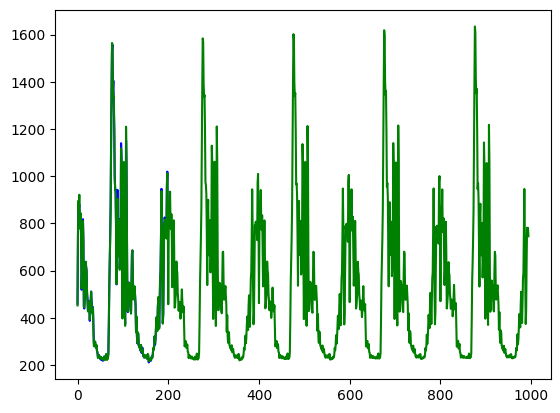

In [57]:
k = 5 # TODO:
start_shift = 0 # TODO
pred_item_in_shift = -1 # TODO
SX_test = X_test[:200]
Sy_test = y_test[:200]
plt.plot((Sy_test[start_shift:, pred_item_in_shift, :]).cpu() * data_std + data_mean, c='b')
plt.plot(pred_next_Kmins(SX_test, k, batch_first=True)[:-k,-1] * data_std + data_mean, c='g')
plt.show()

### TODO:
با همین روش، می‌خواهیم فقط با ورودی دادن داده‌ی ۲۰ دقیقه‌ی اول، داده‌ی ۴۰ دقیقه‌ی آینده را تخمین بزند، نموداری روی یک نمونه از داده‌ی تست رسم کنید که میزان تخمین ما با واقعیت را مقایسه کند.

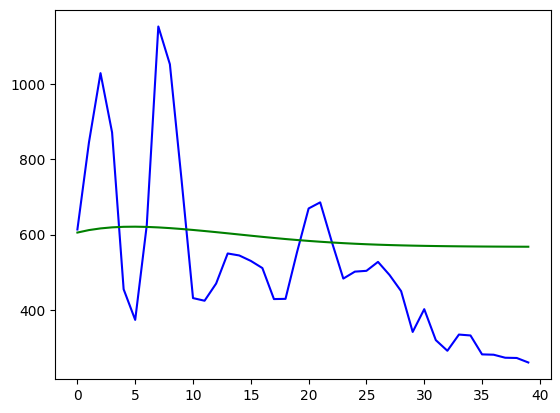

In [62]:
st = 100
plt.plot(y_test[st:st+40, -1, :].cpu() * data_std + data_mean, c='b')
plt.plot(pred_next_Kmins(X_test[st], 40) * data_std + data_mean, c='g')
plt.show()

## ‫ تخمین ۲۰ دقیقه‌ی آینده براساس گذشته


### TODO:
‫
احتمالا نتیجه‌ای که در نمودار آخر قسمت قبل گرفتید، چندان دل‌چسب نبود! در این بخش، می‌خواهیم تلاش کنیم تا نتیجه‌ی بهتری بگیریم. برای این کار اولا، در آموزش مدل، می‌خواهیم به طور مستقیم ۲۰ دقیقه‌ی آینده را تخمین بزنیم. یعنی مدل outputای دهد که تخمینی از زمان عبور از بخش مشخص شده‌ی بزرگراه در ۲۰ دقیقه‌ی آینده باشد.

‫
برای این‌کار، مشابه قسمت قبل دیتاست بسازید، فقط این دفعه مقدار متغیر timeshift را تغییر دهید.

‫
به علاوه در مدل جدید به جای RNN از LSTM استفاده کنید.

‫
به طور کامل جزئیات کاری که کردید را توضیح دهید و مدل، ولیدیشن و نمودارهای مناسب با آن را بسازید.

In [ ]:
X_train, y_train = create_dataset(train_timeseries, 20, 20, 20)
X_test, y_test = create_dataset(test_timeseries, 20, 20, 20)

In [ ]:
#y_train=y_train[:,-1,:]
#y_test=y_test[:,-1,:]

In [ ]:
y_train.size()

torch.Size([2986, 20, 1])

In [ ]:
train_dataset = data.TensorDataset(X_train,y_train )

train_dataloader = data.DataLoader(train_dataset, shuffle=True, batch_size=8)

In [ ]:
class SimpleLookBackLSTMModel(nn.Module):
    def __init__(self,input_size=1, hidden_size=500,fully_connected_size=1000,output_size=1,num_layers=4):
        super().__init__()
        # TODO: implement
        self.LSTM = nn.LSTM(input_size =input_size,
                          hidden_size=hidden_size,num_layers=num_layers,batch_first=True)

        self.batch_norm1 = nn.BatchNorm1d(20)
        self.linear1 = nn.Linear(hidden_size, fully_connected_size)

        self.af1 = nn.ReLU()
        self.batch_norm2 = nn.BatchNorm1d(20)
        self.linear2 = nn.Linear(fully_connected_size, 500)
        self.linear3 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.1)
    def forward(self, x):

        x, _ = self.LSTM(x)
        x = self.batch_norm1(x)
        x = self.dropout(x)
        #x=x[:,-1,:]
        #print(x[:,-1,:].size())
        x = self.af1(self.linear1(x))

        #x=self.linear1(x)

        x = self.batch_norm2(x)
        x = self.dropout(x)
        x=self.linear2(x)
        x = self.linear3(x)
        return x

batch_first = next(iter(train_dataloader))

sample_model = SimpleLookBackLSTMModel().to(device)

print(batch_first[0].shape)
print(sample_model(batch_first[0]).shape)
# both of them should be: torch.Size([8, 20, 1])

torch.Size([8, 20, 1])
torch.Size([8, 20, 1])


In [ ]:
model1 = SimpleLookBackLSTMModel().to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.0001)
#optim.Adam(model1.parameters(), lr=0.0001)
# TODO:
loss_fn = nn.MSELoss()

train_losses = []
valid_losses = []

train_acc = []
valid_acc = []

n_epochs = 20
for epoch in range(n_epochs):
    model1.train()
    for X_batch, y_batch in train_dataloader:
        y_pred = model1(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model1.eval()
    with torch.no_grad():
        y_pred = model1(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train).cpu().item())
        acc_train = R_2_score(X_train, y_train,Training=True)
        train_losses.append(train_rmse.item())
        train_acc.append(acc_train.item())
        y_pred = model1(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test).cpu().item())
        acc_test = R_2_score(X_test,y_test)
        valid_losses.append(test_rmse.item())
        valid_acc.append(acc_test.item())
        print("Epoch %d: train RMSE %.4f, train acc_train %.4f , test RMSE %.4f, test acc_test %.4f" % (epoch, train_rmse,acc_train ,test_rmse,acc_test))
        #plt.plot(y_test[-300:, -1, :] * data_std + data_mean, c='b')
        #plt.plot(y_pred[-300:, -1, :] * data_std + data_mean, c='g')
        #plt.show()

Epoch 0: train RMSE 0.5459, train acc_train 0.7262 , test RMSE 0.4477, test acc_test 0.6728
Epoch 1: train RMSE 0.5434, train acc_train 0.7287 , test RMSE 0.4400, test acc_test 0.6841
Epoch 2: train RMSE 0.5440, train acc_train 0.7281 , test RMSE 0.4659, test acc_test 0.6458
Epoch 3: train RMSE 0.4983, train acc_train 0.7718 , test RMSE 0.4048, test acc_test 0.7326
Epoch 4: train RMSE 0.5017, train acc_train 0.7688 , test RMSE 0.4375, test acc_test 0.6876
Epoch 5: train RMSE 0.4857, train acc_train 0.7833 , test RMSE 0.4019, test acc_test 0.7363
Epoch 6: train RMSE 0.4759, train acc_train 0.7919 , test RMSE 0.3841, test acc_test 0.7592
Epoch 7: train RMSE 0.5289, train acc_train 0.7430 , test RMSE 0.4686, test acc_test 0.6417
Epoch 8: train RMSE 0.4516, train acc_train 0.8126 , test RMSE 0.3732, test acc_test 0.7726
Epoch 9: train RMSE 0.4484, train acc_train 0.8153 , test RMSE 0.3734, test acc_test 0.7725
Epoch 10: train RMSE 0.4975, train acc_train 0.7726 , test RMSE 0.4394, test acc

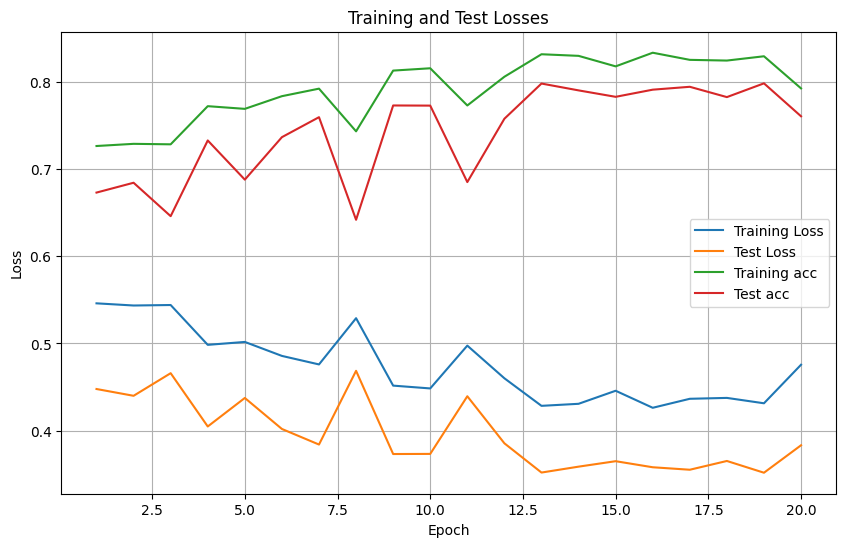

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs+1), valid_losses, label='Test Loss')
plt.plot(range(1, n_epochs+1), train_acc, label='Training acc')
plt.plot(range(1, n_epochs+1), valid_acc, label='Test acc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.grid(True)
plt.show()

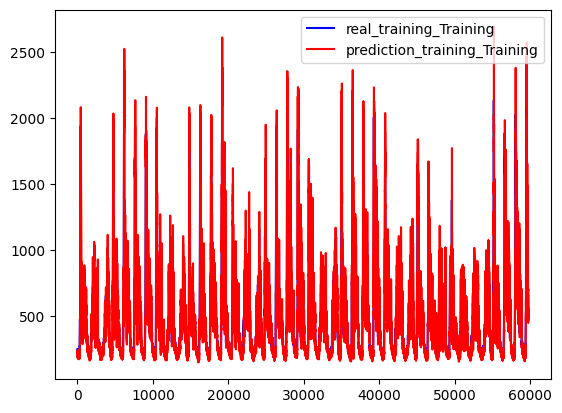

R^2 Score_Training: 0.7922209470634133


,Real Data,Predictions
0,247.463943,232.095245
1,245.180389,216.633057
2,244.078506,203.783295
3,242.494110,192.389465
4,240.569046,187.168976
...,...,...
59715,683.889526,495.691345
59716,696.217224,508.667603
59717,704.989136,476.429169
59718,703.325073,474.204224


In [ ]:
Data=R_2_score(X_train,y_train,Training=True,Print=True)
Data

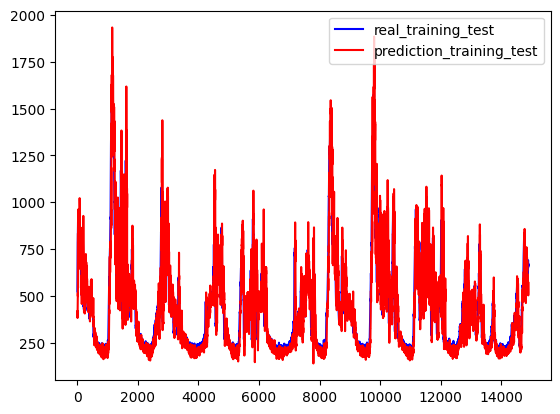

R^2 Score_test: 0.7602521348714116


,Real Data,Predictions
0,523.403076,418.199615
1,534.516724,415.882538
2,537.842041,417.612000
3,576.958130,414.261780
4,616.364075,390.303894
...,...,...
14895,674.160706,559.470520
14896,662.324768,525.159790
14897,653.696960,507.457153
14898,661.842468,503.193634


In [ ]:
Data=R_2_score(X_test,y_test,Print=True)
Data